In [69]:
import matplotlib.pyplot as plt
import numpy as np
from uncertainties import ufloat, UFloat
from uncertainties import unumpy as unp

from spe_funcs import load_data

In [70]:
dists = np.array([5, 10, 16, 22, 28, 34, 40]) # in cm
files = [f"data/Zeitkalibrierung-Na22-BaF2-{d}cm.Spe" for d in dists]

In [71]:
from lmfit.models import GaussianModel
def get_time_center(filepath: str, num: int):
    data, _ = load_data(filepath, only_roi=False)
    roi = np.arange(2150, 2350) - num * 20
    data = data[roi]
    model = GaussianModel()
    
    # uncertainty of mcb is <1% differential nonlinearity, choose worst case
    adapted_data = data * 0.01
    adapted_data[adapted_data == 0.] = 1
    weights = np.array(1.0/adapted_data)
    
    init_values = {
        'amplitude': {'value': 1900, 'min': 0, 'max': 2200},
        'center': {'value': roi[np.where(data == max(data))[0][0]], 'min': roi[0], 'max': roi[-1]},
        'sigma': {'value': 20, 'min': 0, 'max': 1000},
    }
    params = model.make_params(**init_values)
    result = model.fit(data, params, x=list(roi), weights=weights)
    # efine = result.eval_uncertainty(t=roi, sigma=2)
    # pfine = result.dely_predicted
    fitted_params = result.params
    # fitted_params.pretty_print()
    
    x = np.linspace(min(roi), max(roi), 1000)
    y = model.eval(x=x, params=fitted_params)
    # plt.fill_between(roi, data-pfine, data+pfine,
    #                  color="#c0c0c0", label=r'$2\sigma$ predicted interval')
    plt.plot(x, y, linewidth=.4, c='orange', label='Gauss Fit')
    plt.scatter(roi, data, s=0.1, label='Flugzeitspektrum')
    plt.grid(alpha=.3)
    plt.legend()
    plt.xlabel('Channel')
    plt.ylabel('Counts')
    plt.show()
    
    center = ufloat(fitted_params['center'].value, fitted_params['center'].stderr)
    return center

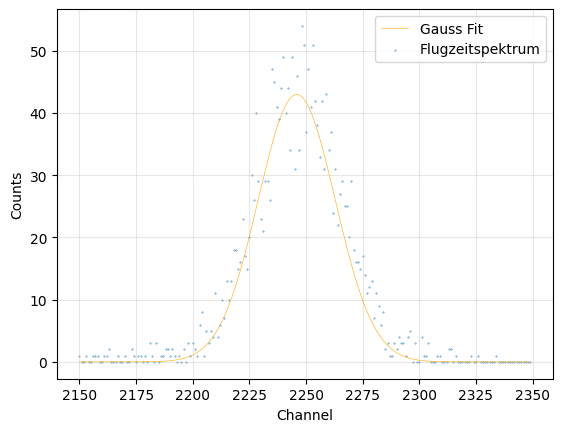

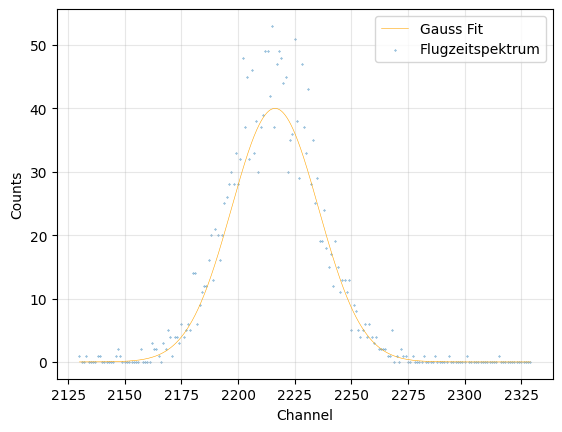

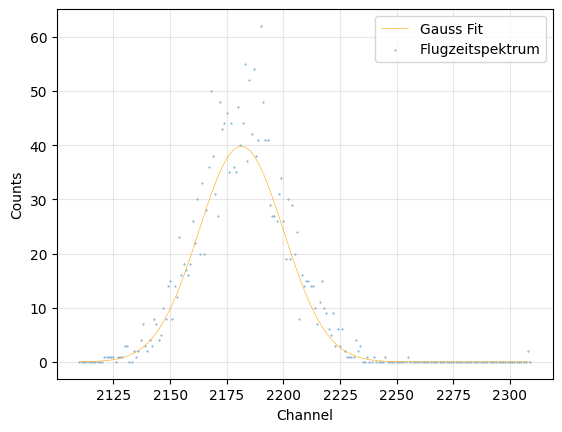

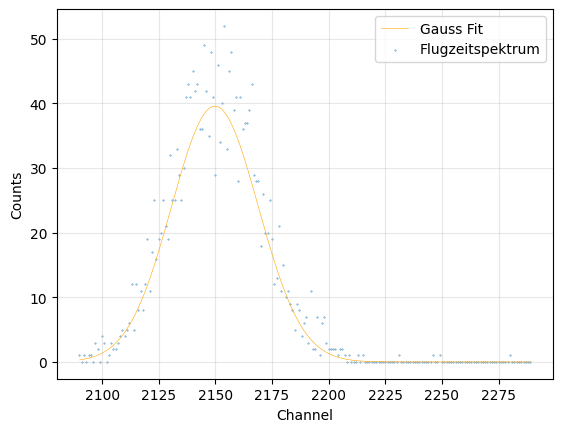

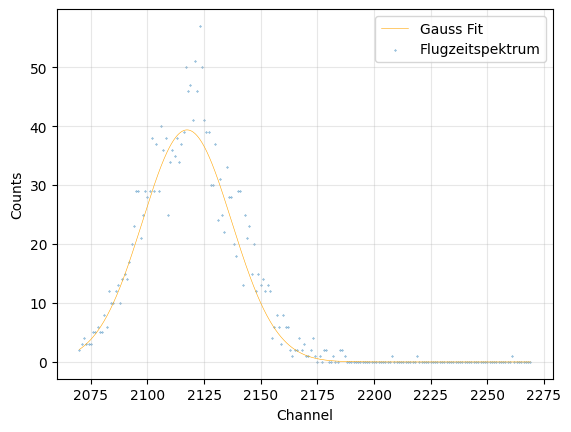

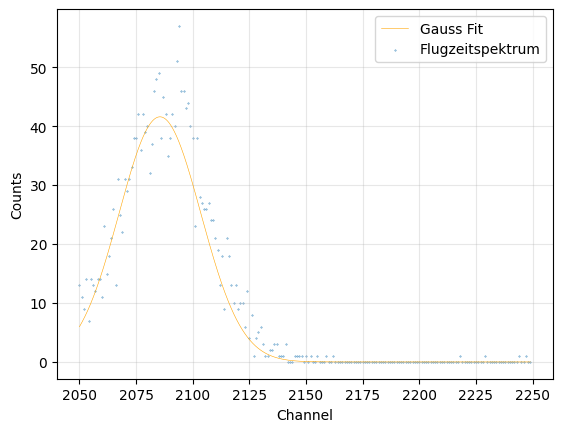

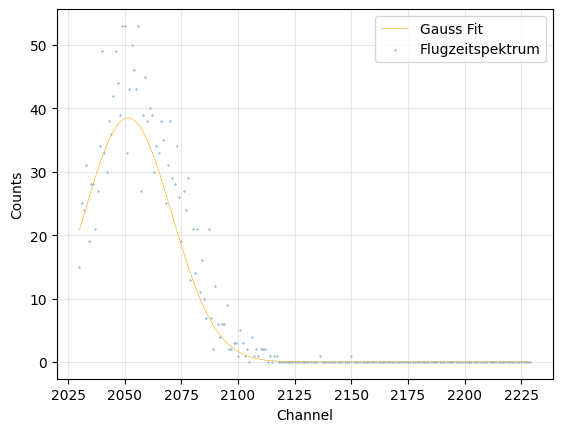

In [72]:
vals = []
stds = []
centers = [get_time_center(file, num) for num, file in enumerate(files)]
for c in centers:
    vals.append(c.n)
    stds.append(c.s)
centers = unp.uarray(vals, stds)

In [73]:
print(centers)

[2245.8866081038154+/-0.5566448491732631
 2216.3230284185115+/-0.401352860548809
 2181.427228888797+/-0.3422426301396129
 2149.7955601110657+/-0.3712154247722528
 2117.480969405051+/-0.3917241691011771
 2085.530246256675+/-0.6675896308603382
 2051.4404924196438+/-1.131085512939092]


In [74]:
cen_vals = unp.nominal_values(centers)
cen_stds = unp.std_devs(centers)

In [75]:
from lmfit.models import LinearModel
lin_model = LinearModel()
init_values_lin = {
    'slope': {'value': -0.17, 'min': -1, 'max': 0},
    'intercept': {'value': 2250, 'min': 2200, 'max': 2500},
}
params_lin = lin_model.make_params(**init_values_lin)

In [76]:
from scipy.constants import c
lightspeed = c * 100 * 10**-12 # in cm/ps
print('lightspeed:', lightspeed, 'cm/ps')
dists = np.array(dists - min(dists))
dists = unp.uarray(dists, np.zeros_like(dists)+1.)
times = np.array(dists)/lightspeed # in ps
time_vals = unp.nominal_values(times)
time_stds = unp.std_devs(times)
print(times, "ps")

lightspeed: 0.0299792458 cm/ps
[0.0+/-33.35640951981521 166.78204759907604+/-33.35640951981521
 366.9205047179673+/-33.35640951981521
 567.0589618368585+/-33.35640951981521
 767.1974189557498+/-33.35640951981521
 967.335876074641+/-33.35640951981521
 1167.4743331935322+/-33.35640951981521] ps


In [77]:
cen_weights = 1.0/(cen_stds+unp.std_devs(times))

In [78]:
lin_result = lin_model.fit(cen_vals, params_lin, x=unp.nominal_values(times), weights=cen_weights)
fitted_params_lin = lin_result.params
fitted_params_lin.pretty_print()

Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
intercept      2244     2200     2500   0.9162     True     None     None
slope       -0.1651       -1        0 0.001328     True     None     None


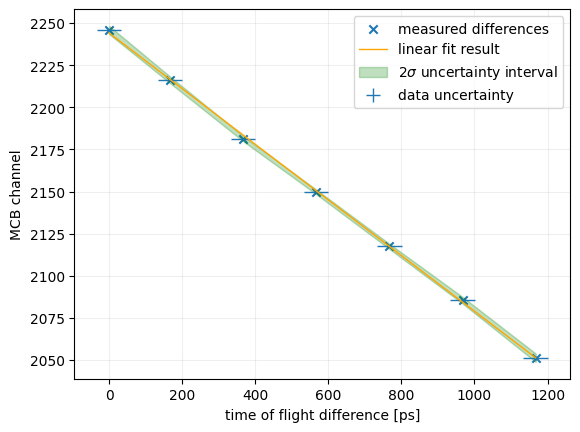

In [108]:
x = np.linspace(min(time_vals), max(time_vals), 10000)
y = lin_model.eval(x=x, params=fitted_params_lin)
uncert = lin_result.eval_uncertainty(x=time_vals, sigma=2)
plt.scatter(time_vals, cen_vals, label='measured differences', marker='x')
plt.errorbar(time_vals, cen_vals, xerr=time_stds, yerr=cen_stds, fmt='none', elinewidth=1, label='data uncertainty')
plt.plot(x, y, linewidth=1, c='orange', label='linear fit result')
plt.fill_between(time_vals, cen_vals-uncert, cen_vals+uncert, alpha=0.25, color='green', label=r"$2\sigma$ uncertainty interval")
plt.grid(alpha=.2)
plt.legend()
plt.xlabel('time of flight difference [ps]')
plt.ylabel('MCB channel')
plt.show()

In [103]:
time_resolution = abs(1./ufloat(fitted_params_lin["slope"].value, fitted_params_lin["slope"].stderr))
print(f'Time resolution for BAF2 detector: {time_resolution} ps/channel')

Time resolution for BAF2 detector: 6.06+/-0.05 ps/channel
